# Seminar 01: Naive Bayes from scratch

## Loading data


In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets

In [274]:
matplotlib.rcParams['font.size'] = 15

In [3]:
dataset = datasets.load_iris()
print(dataset.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [4]:
ext_target = dataset.target[:, None]
# ext_target = np.expand_dims(dataset.target, axis=-1)
df = pd.DataFrame(
    np.concatenate((dataset.data, ext_target, dataset.target_names[ext_target]), axis=1),
    columns=dataset.feature_names + ['target label', 'target name'],
)
df.head()

sepal length (cm) sepal width (cm) petal length (cm) petal width (cm)  \
0               5.1              3.5               1.4              0.2   
1               4.9              3.0               1.4              0.2   
2               4.7              3.2               1.3              0.2   
3               4.6              3.1               1.5              0.2   
4               5.0              3.6               1.4              0.2   

  target label target name  
0            0      setosa  
1            0      setosa  
2            0      setosa  
3            0      setosa  
4            0      setosa

In [5]:
features = dataset.data
target = dataset.target

features.shape, target.shape

((150, 4), (150,))

## Visualize dataset

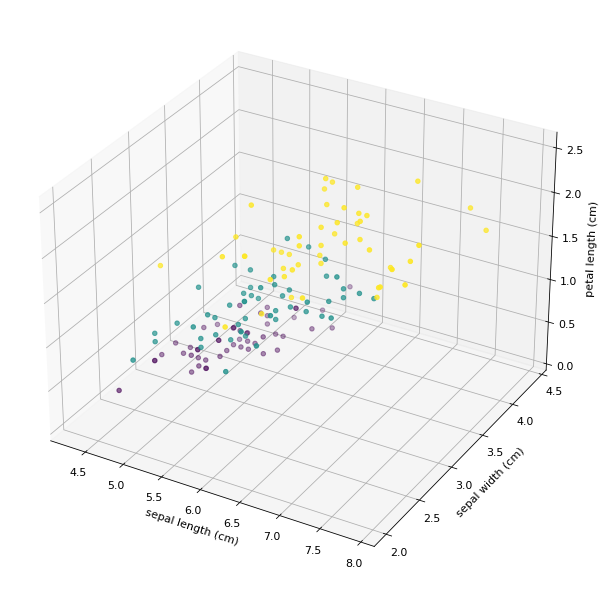

In [7]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 8))

ax = Axes3D(fig)

ax.scatter(features[:, 0], features[:, 1], features[:, 3], c=target, marker='o')
ax.set_xlabel(dataset.feature_names[0])
ax.set_ylabel(dataset.feature_names[1])
ax.set_zlabel(dataset.feature_names[2])
plt.show()

In [8]:
import plotly.express as px

fig = plt.figure(figsize=(8, 8))
fig = px.scatter_3d(df, x='sepal length (cm)', y='sepal width (cm)', z='petal width (cm)',
                    color='target name')
fig.show()

<Figure size 576x576 with 0 Axes>

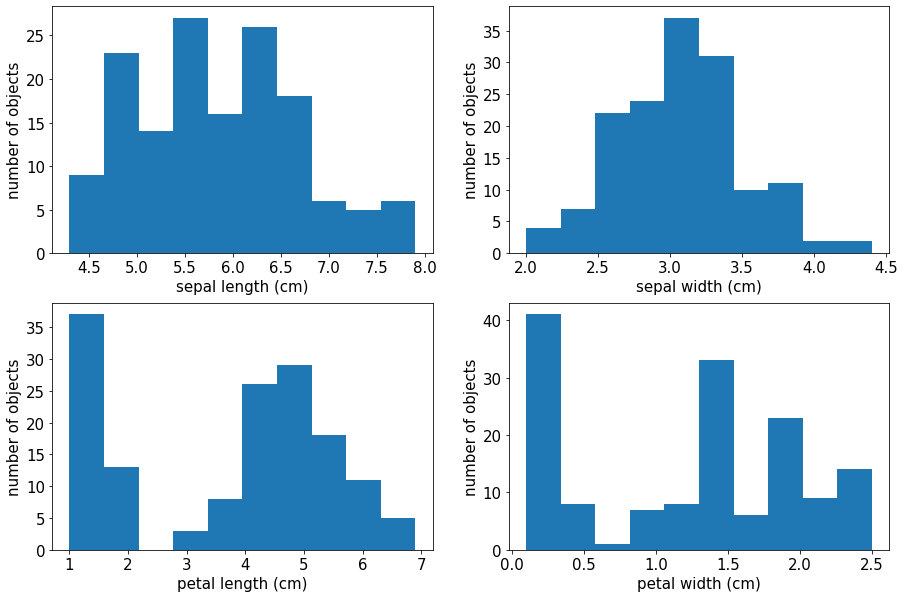

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for i, axis in enumerate(axes.flat):
    axis.hist(features[:, i])
    axis.set_xlabel(dataset.feature_names[i])
    axis.set_ylabel('number of objects')

## Classifier implementation


Since we aiming to implement Naive Bayes algorithm first we need some prior distribution defined.

The most common distribution is (of course) Gaussian and it's params are mean and standard deviation. Let's implement class taking list of feature values, estimating distribution params and able to give probability density of any given feature value.

Denote the normal distribution $\mathcal{N}(\mu, \sigma^2)$ PDF:$$
f(x|\mu, \sigma^2) = \frac{1}{\sigma\sqrt{2\pi}}\exp(-\frac{(x - \mu)^2}{2\sigma^2})
$$Let's implement the GaussianDistribution class. (Of course in practice one could always use something like scipy.stats.norm).

Please note, that making computations with log probabilities is more stable.

In [32]:
class GaussianDistribution:
    def __init__(self, feature):
        """
        Args:
            feature: column of design matrix, represents all available values
                of feature to model.
                axis=0 stays for samples.
        """
        self.mean = feature.mean(axis=0)
        self.std = feature.std(axis=0)
        
    def logpdf(self, value):
        """Logarithm of probability density at value"""
        return (-0.5 * (value - self.mean)**2 / self.std**2) - np.log(self.std) + 0.5 * (-np.log(np.pi) - np.log(2.))
    def pdf(self, value):
        return np.exp(self.logpdf(value))

## Probabilistic model
Let's focus on the classification problem now. For the case of $K$ classes label $y_i \in \{C_1, \ldots, C_k\}$. Iris classification problem has 3 classes, so $K=3$. Bayes' Theorem takes the following form:

$$
P(y_i = C_k|\mathbf{x}_i) = \frac{P(\mathbf{x}_i|y_i = C_k) P(y_i = C_k)}{P(\mathbf{x}_i)}
$$
Please note, we prefer working with log probabilities here as well. So the equation above will take the following form:$$
\log P(y_i = C_k|\mathbf{x}_i) = \log P(\mathbf{x}_i|y_i = C_k) + \log P(y_i = C_k) - \log P(\mathbf{x}_i)
$$

As one could mention, to find the class label with the highest probability we even do not need the last term $P(\mathbf{x}_i)$. However, we need it to get the correct estimation of the probability $P(y_i = C_k|\mathbf{x}_i)$.

The $P(\mathbf{x}_i)$ term can be computed using the following property:$$
P(\mathbf{x}_i) = \sum_{k=1}^K P(y_i = C_k)  P(\mathbf{x}_i|y_i=C_k).
$$It can be computed from $\log P(\mathbf{x}_i|y_i=C_k)$ values using logsumexp function located in scipy.special.

Now let's implement the Naive Bayes classifier itself. The class below is inherited from sklearn base classes and provides all the main methods.

In [48]:
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.special import logsumexp

In [177]:
class NaiveBayes(BaseEstimator, ClassifierMixin):
    """
    Please note, using `X` and `y` for design matrix and labels in general is not a good choice,
    better stick to more informative naming conventions.
    However, to make the code consistent with sklearn implementation, we use `X` and `y` variables here.
    """
    def fit(self, X, y, sample_weight=None, distributions=None):
        '''
        sample_weight 
            The argument is ignored. For comatibility only.
        '''
        assert sample_weight is None
        self.unique_labels = np.unique(y)
        
        # If distributions of features are not specified, they a treated Gaussian
        
        if distributions is None:
            distributions = [GaussianDistribution] * X.shape[1]
        else:
            assert len(distributions) == X.shape[1]
            
        # Here we find distribution parameters for every feature in every class subset
        # so P(x^i|y=C_k) will be estimated only using information from i-th feature of C_k class values
        
        self.conditional_feature_distribution = {}  # label: [distribution for feature 1, ...]
        
        for label in self.unique_labels:
            feature_distribution = []
            for column_index in range(X.shape[1]):
                # `column_index` feature values for objects from `label` class
                feature_column = X[y == label, column_index]
                fitted_distr = distributions[column_index](feature_column)
                feature_distribution.append(fitted_distr)
            self.conditional_feature_distribution[label] = feature_distribution
        
        # Prior label distributions (unconditional probability of each class)
        self.prior_label_distibution = {
            #  кол-во объектов выборки каждого класса
            label: sum((label == self.unique_labels).astype(float)) / len(self.unique_labels)
            for label in self.unique_labels
        }
        
    def predict_log_proba(self, X):
        # Matrix of shape (n_objects, n_classes)
        class_log_probas = np.zeros((X.shape[0], len(self.unique_labels)), dtype=float)
        
        #Here we compute the class log probabilities for each class sequentially
        for label_idx, label in enumerate(self.unique_labels):
            for idx in range(X.shape[1]):
                # All loglikelihood for every feature w.r.t. fixed label
                
                class_log_probas[:, label_idx] += self.conditional_feature_distribution[label][idx].logpdf(X[:, idx])
                
            # Add log proba of label prior    
            class_log_probas[:, label_idx] += np.log(self.prior_label_distibution[label])
        
        for idx in range(X.shape[1]):
            # If you want to get probabilities, you need to substract the log proba for every feature
            class_log_probas -= logsumexp(class_log_probas, axis=1)[:, None]
        return class_log_probas
    
    def predict_proba(self, X):
        return np.exp(self.predict_log_proba(X))
    
    def predict(self, X):
        log_probas = self.predict_log_proba(X)
        # we need to cast labels to their original form (they may start from number other than 0)
        return np.array([self.unique_labels[idx] for idx in log_probas.argmax(axis=1)])

In [178]:
nb = NaiveBayes()
nb.fit(features, target)
print('log probas:\n{}'.format(nb.predict_log_proba(features[:2])))
print('predicted labels:\n{}'.format(nb.predict(features[:2])))
print('\nIt`s alive! More tests coming.')

log probas:
[[  0.         -41.14063634 -57.90531295]
 [  0.         -38.72865982 -56.71097942]]
predicted labels:
[0 0]

It`s alive! More tests coming.


In [180]:
from sklearn.model_selection import train_test_split
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=24)

print(features_train.shape, features_test.shape)

(112, 4) (38, 4)


In [181]:
nb = NaiveBayes()
nb.fit(features_train, target_train, distributions=[GaussianDistribution]*4)
nb_test_log_proba = nb.predict_log_proba(features_test)

In [182]:
print('Naive Bayes classifier accuracy on the train set: {}'.format(nb.score(features_train, target_train)))

Naive Bayes classifier accuracy on the train set: 0.9553571428571429


In [183]:

print('Naive Bayes classifier accuracy on the test set: {}'.format(nb.score(features_test, target_test)))

Naive Bayes classifier accuracy on the test set: 0.9473684210526315


Finally, let's compare the Naive Bayes classifier with the $sklearn$ implementation.

In [184]:
from sklearn import naive_bayes

sklearn_nb = naive_bayes.GaussianNB()
sklearn_nb.fit(features_train, target_train)
sklearn_nb_test_log_proba = sklearn_nb.predict_log_proba(features_test)

In [185]:

print('sklearn implementation accuracy on the train set: {}'.format(sklearn_nb.score(features_train, target_train)))

sklearn implementation accuracy on the train set: 0.9642857142857143


In [186]:

print('sklearn implementation accuracy on the test set: {}'.format(sklearn_nb.score(features_test, target_test)))

sklearn implementation accuracy on the test set: 0.9473684210526315


And let's even check the predictions. If you used Gaussian distribution and done everything correctly, the log probabilities should be the same.

### Comparing to kNN

In [190]:
from sklearn.neighbors import KNeighborsClassifier

In [191]:
knn = KNeighborsClassifier(n_neighbors=3)

In [192]:
knn.fit(features_train, target_train)

KNeighborsClassifier(n_neighbors=3)

In [193]:
knn.score(features_train, target_train)

0.9642857142857143

In [194]:
knn.score(features_test, target_test)

0.9736842105263158

Seem like Naive Bayes classifier performance is comparable to the kNN, while Naive Bayes does not need to store all the train data (while kNN need).

### Advanced distribution for NaiveBayes
Let's take a look at violin plots for every feature in our dataset:

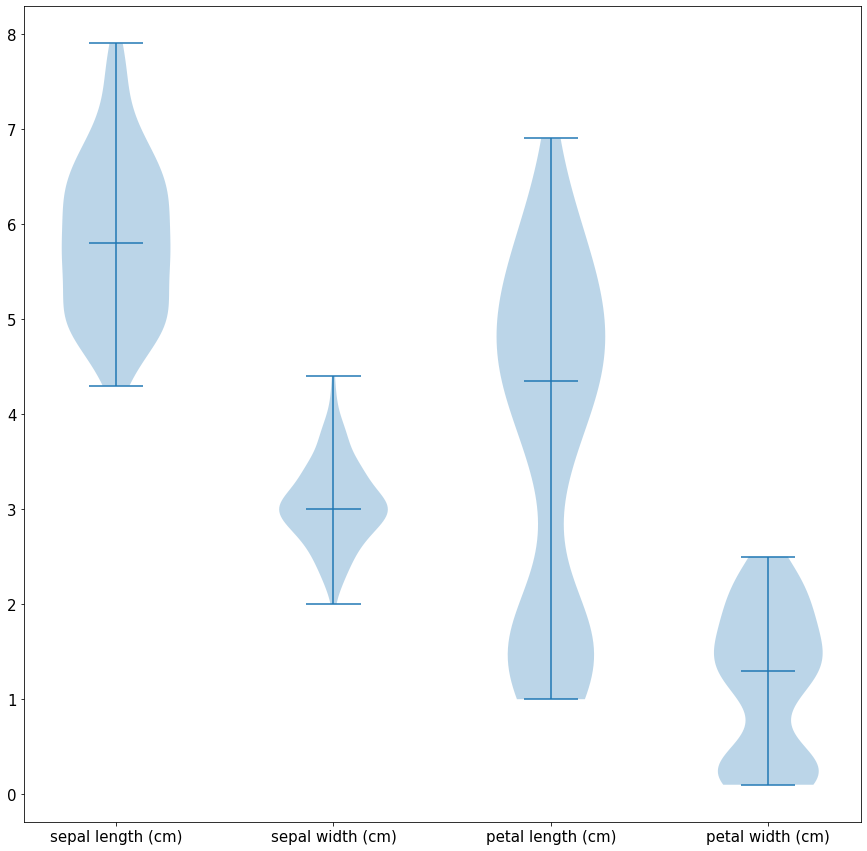

In [200]:
labels = df.columns[:4]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15), sharey=True)
plt.violinplot(features, showmedians=True)
ax.set_xticks(np.arange(1, len(labels) + 1))
ax.set_xticklabels(labels)
plt.show()


Although we do love Gaussian distribution it is still unimodal while our features are substantially multimodal (see histograms above). So we have to implement more robust distribution estimator - Kernel Density Estimator (KDE).

Idea for this method is simple: we assign some probability density to a region around actual observation. (We will return to density estimation methods to describe them carefully later in this course).

Fortunately sklearn have KDE implemented for us already. All it needs is vector of feature values.

To get probability estimations using KDE one can easily access the sklearn.neighbors module.

Text(0, 0.5, 'probability')

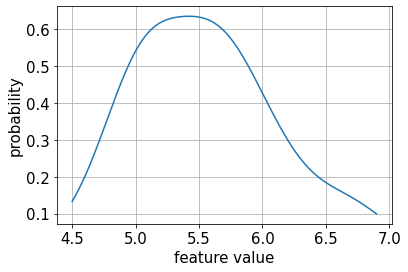

In [220]:
from sklearn.neighbors import KernelDensity
kde = KernelDensity(bandwidth=0.28, kernel='gaussian')
feature_col = features[target==2, 2]
kde.fit(feature_col.reshape((-1, 1)))
linspace = np.linspace(feature_col.min(), feature_col.max(), 1000)
plt.plot(linspace, np.exp(kde.score_samples(linspace.reshape((-1, 1)))))
plt.grid()
plt.xlabel('feature value')
plt.ylabel('probability')

To make it compatible with the Naive Bayes classifier we have implemented above, we need to create class with the same methods:

In [261]:
class GaussianKDE:
    def __init__(self, feature):
        self.kde = KernelDensity(bandwidth=0.3)
        self.kde.fit(feature.reshape((-1, 1)))
        
    def logpdf(self, value):
        return self.kde.score_samples(value.reshape((-1, 1)))
    
    def pdf(self, value):
        return np.exp(self.logpdf(value))

In [262]:
nb_kde = NaiveBayes()
nb_kde.fit(features, target, distributions=[GaussianKDE]*4)
print('log probas:\n{}'.format(nb_kde.predict_log_proba(features[:2])))
print('predicted labels:\n{}'.format(nb_kde.predict(features[:2])))
print('\nIt`s alive!')

log probas:
[[-7.16027237e-12 -2.56624634e+01 -7.23622952e+01]
 [-2.33491004e-11 -2.44804629e+01 -7.14003363e+01]]
predicted labels:
[0 0]

It`s alive!


In [263]:
print('KDE Naive Bayes classifier accuracy on the train set: {}'.format(nb_kde.score(features_train, target_train)))

KDE Naive Bayes classifier accuracy on the train set: 0.9642857142857143


In [264]:
print('KDE Naive Bayes classifier accuracy on the test set: {}'.format(nb_kde.score(features_test, target_test)))

KDE Naive Bayes classifier accuracy on the test set: 0.9736842105263158


Seems like the accuracy of the classifier has decreased. What is going on?

Hint: try varying the bandwidth parameter of the KernelDensity constructor in GaussianKDE class (around 0.3).

Let's take a closer look on the features distributions. Here comes the histogram:

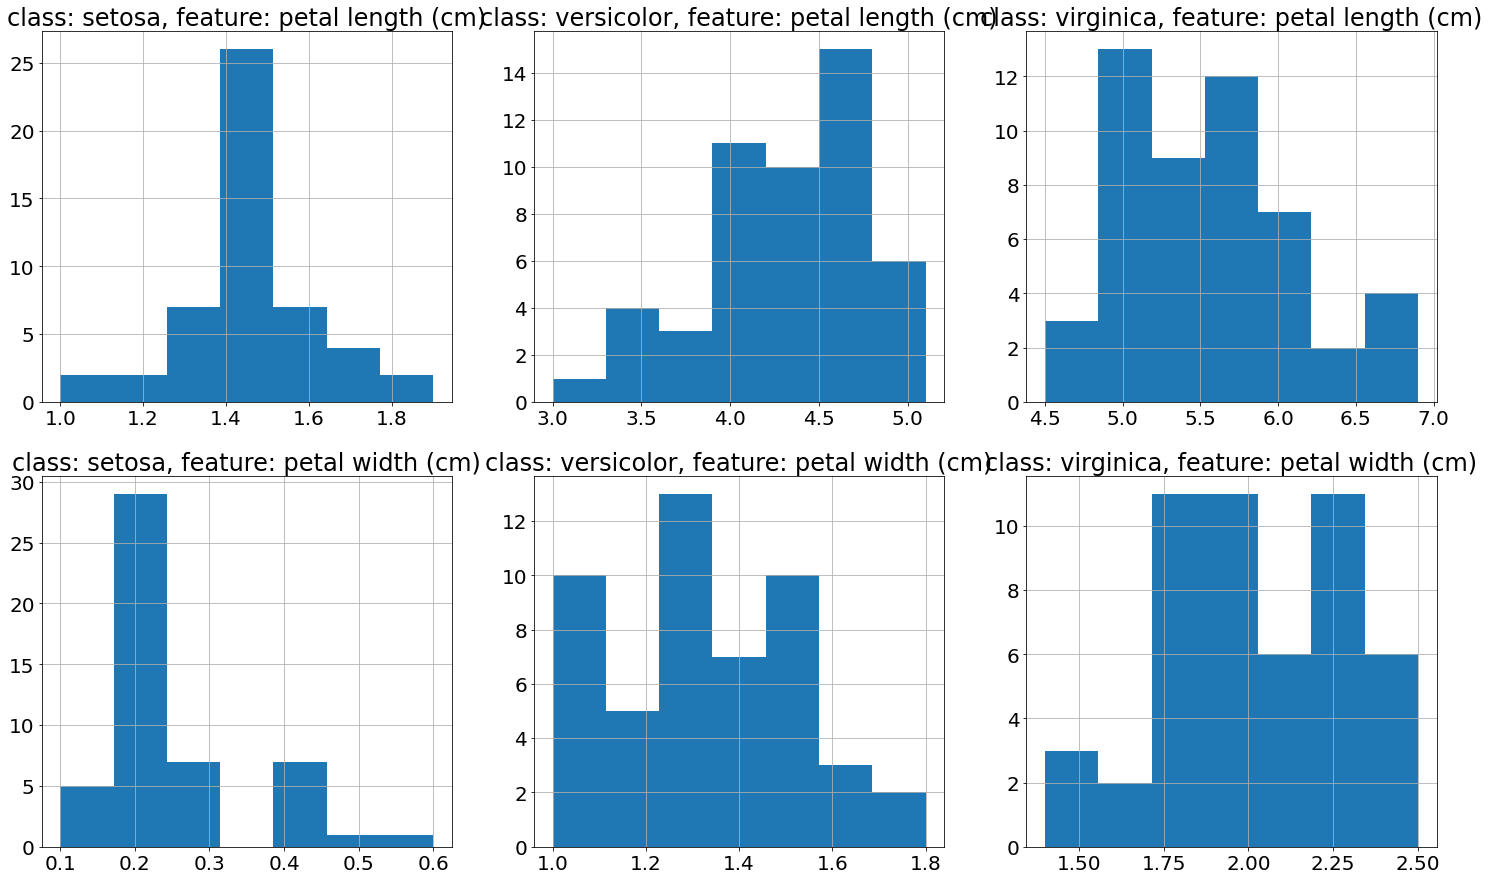

In [268]:
fig, axes = plt.subplots(2, 3, figsize=(25, 15))

for ax_idx, feature_idx in enumerate([2, 3]):
    for label in range(3):
        ax = axes[ax_idx, label]
        feature_col = features[target==label, feature_idx]
        ax.hist(feature_col, bins=7)
        ax.grid()
        ax.set_title('class: {}, feature: {}'.format(
            dataset.target_names[label],
            dataset.feature_names[feature_idx]
        ))

We see, than the distributions within every class are unimodal. That's how KDE is approximating the PDF:

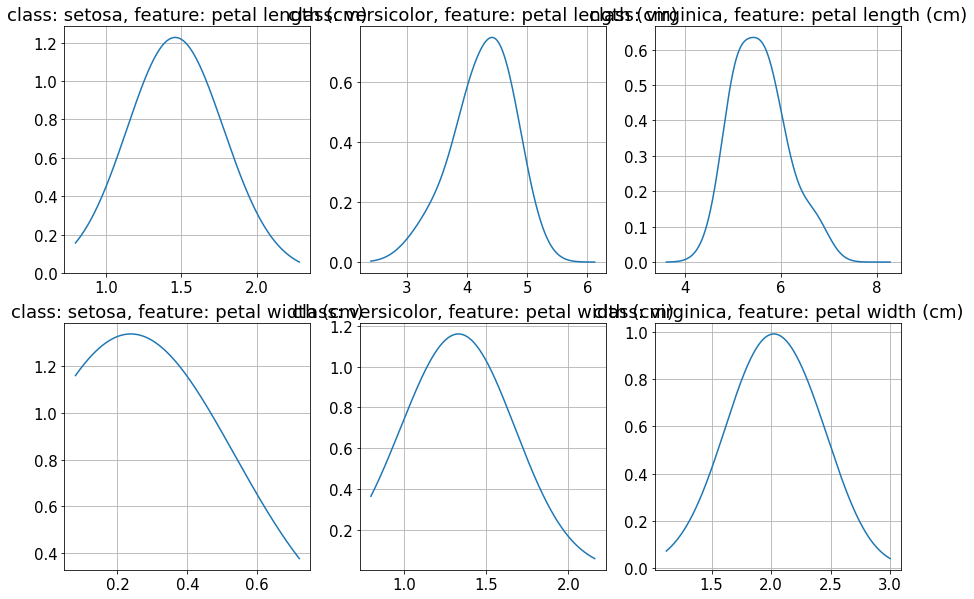

In [275]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
kde = KernelDensity(bandwidth=0.28, kernel='gaussian')

for ax_idx, feature_idx in enumerate([2, 3]):
    for label in range(3):
        ax = axes[ax_idx, label]
        feature_col = features[target==label, feature_idx]
        kde.fit(feature_col.reshape((-1, 1)))
        linspace = np.linspace(
            0.8*feature_col.min(),
            1.2*feature_col.max(),
            1000
        )
        ax.plot(linspace, np.exp(kde.score_samples(linspace.reshape((-1, 1)))))
        ax.grid()
        ax.set_title('class: {}, feature: {}'.format(
            dataset.target_names[label],
            dataset.feature_names[feature_idx]
        ))

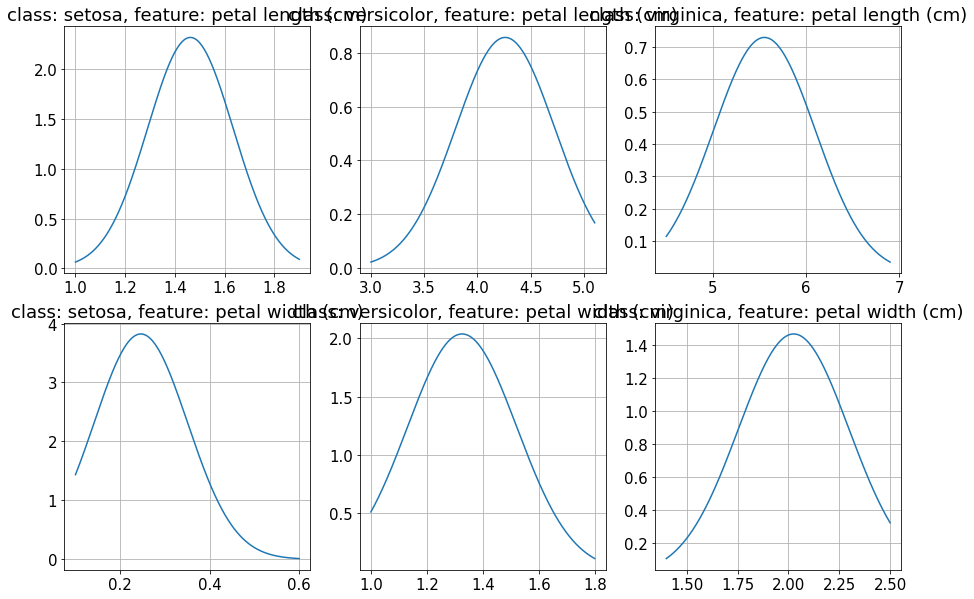

In [276]:

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for ax_idx, feature_idx in enumerate([2, 3]):
    for label in range(3):
        ax = axes[ax_idx, label]
        feature_col = features[target==label, feature_idx]
        gaussian_distr = GaussianDistribution(feature_col)
        linspace = np.linspace(
            feature_col.min(),
            feature_col.max(),
            1000
        )
        ax.plot(linspace, gaussian_distr.pdf(linspace.reshape((-1, 1))))
        ax.grid()
        ax.set_title('class: {}, feature: {}'.format(
            dataset.target_names[label],
            dataset.feature_names[feature_idx]
        ))

Looks a bit better. Moreover, hypothesis of the normal distribution over the features seems more promising (the features are petal length and width).

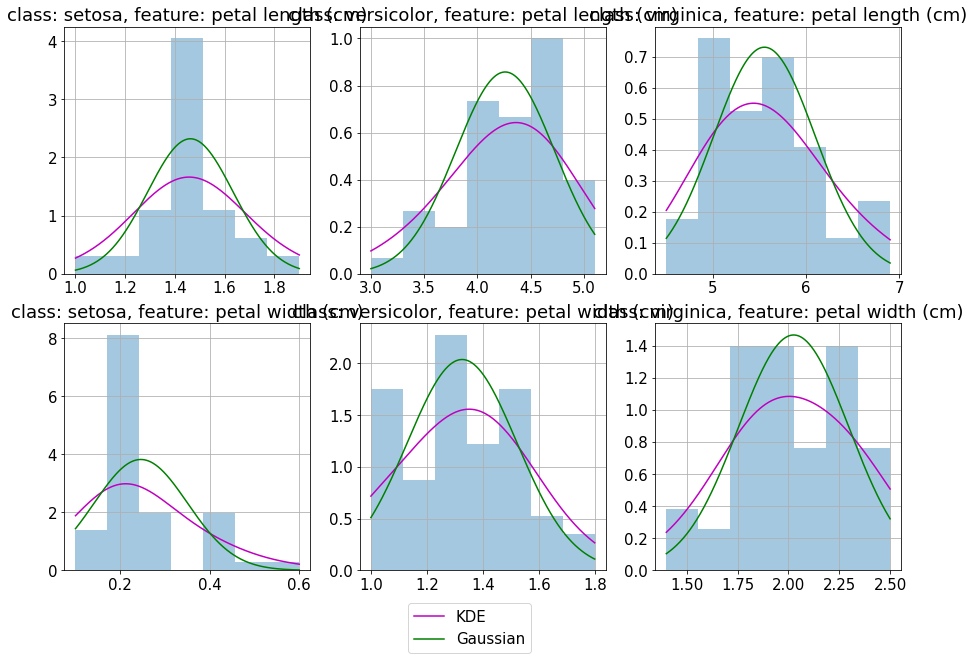

In [277]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for ax_idx, feature_idx in enumerate([2, 3]):
    for label in range(3):
        ax = axes[ax_idx, label]
        feature_col = features[target==label, feature_idx]
        ax.hist(feature_col, bins=7, density=True, alpha=0.4)
                
        bandwidth = abs((feature_col.min() - feature_col.max()) / 5)
        kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
        kde.fit(feature_col.reshape((-1, 1)))
        linspace = np.linspace(
            feature_col.min(),
            feature_col.max(),
            1000
        )
        ax.plot(linspace, np.exp(kde.score_samples(linspace.reshape((-1, 1)))), c='m', label='KDE')
        
        gaussian_distr = GaussianDistribution(feature_col)
        linspace = np.linspace(
            feature_col.min(),
            feature_col.max(),
            1000
        )
        ax.plot(linspace, gaussian_distr.pdf(linspace.reshape((-1, 1))), c='g', label='Gaussian')        
        
        ax.grid()
        ax.set_title('class: {}, feature: {}'.format(
            dataset.target_names[label],
            dataset.feature_names[feature_idx]
        ))

labels_handles = {
  label: handle for ax in fig.axes for handle, label in zip(*ax.get_legend_handles_labels())
}
fig.legend(
  labels_handles.values(),
  labels_handles.keys(),
  loc="lower center",
  bbox_to_anchor=(0.5, 0),
  bbox_transform=plt.gcf().transFigure,
)


So, the conclusion: always check the distribution and the assumptions you make. They should be appropriate for the data you work with.